# Environment:

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import Caltech256
import timm
from tqdm import tqdm
import os

In [50]:
from sklearn.metrics.pairwise import euclidean_distances
from PIL import Image

# Model and Data Initialization:

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

In [35]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet50
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Convert grayscales to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
data_dir = './caltech256'
caltech256 = Caltech256(root=data_dir, download=True, transform=preprocess)
dataloader = DataLoader(caltech256, shuffle=False)

Files already downloaded and verified


In [37]:
def extract_resnet_features(img_path):
    # Load ResNet50 model, without the classification layer
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = resnet_preprocess_input(img_array)

    # Extract features
    features = model.predict(img_array)
    return features  # 2048-dimensional vector

In [38]:
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])  # Remove the classification layer
resnet_model = resnet_model.to(device)
resnet_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


# Encoding image into vectors with the model:

In [39]:
def encode_images_resnet(dataloader, device):

    all_features = []
    all_labels = []

    for images, labels in dataloader:

        images = images.to(device)

        with torch.no_grad():
            features = resnet_model(images)
            features = features.view(features.size(0), -1)  # Flatten features

        all_features.append(features.cpu())
        all_labels.append(labels)

    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)

    return all_features, all_labels

In [ ]:
start_time = time.time()
resnet_features, labels = encode_images_resnet(dataloader, device)
end_time = time.time()

In [42]:
print("Time Taken:", end_time - start_time, "seconds")
print(f"ResNet50 Features: {resnet_features.shape}")

Time Taken: 347.36605429649353 seconds
ResNet50 Features: torch.Size([30607, 2048])


## Sample Image and its vector representation:

In [43]:
def show_image(image_tensor):
    image = image_tensor.squeeze(0)
    image = image.permute(1, 2, 0).cpu().numpy()  # Dimensions (C, H, W) -> (H, W, C)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

First image in the dataset:


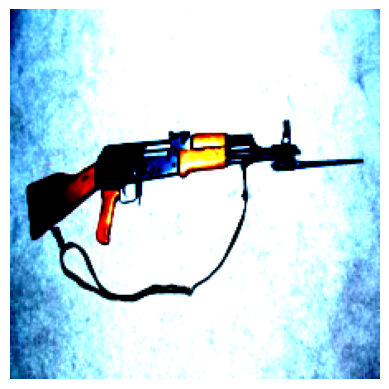


CLIP vector representation of the first image:
[[[[0.58949304]]

  [[0.4161868 ]]

  [[0.73445845]]

  ...

  [[0.32072106]]

  [[0.02718895]]

  [[0.11703241]]]]

Class label of the first image:  001.ak47


In [45]:
# Get the first image and label from the dataloader
first_image, first_label = next(iter(dataloader))  # Directly unpack the first batch

# Convert the label to integer
first_label = first_label.item()

# Accessing the class names from the dataset within the dataloader
class_names = dataloader.dataset.categories  # Caltech256 uses 'categories'

print("First image in the dataset:")
show_image(first_image)  # Function to display the image

# Move the image to the device
first_image = first_image.to(device)

with torch.no_grad():
    first_image_features = resnet_model(first_image)

# Retrieve the class name corresponding to the label
first_image_class = class_names[first_label]  # Mapping label to class name

print("\nCLIP vector representation of the first image:")
print(first_image_features.cpu().numpy())

print("\nClass label of the first image: ", first_image_class)

# Content Based Image Retrieval:

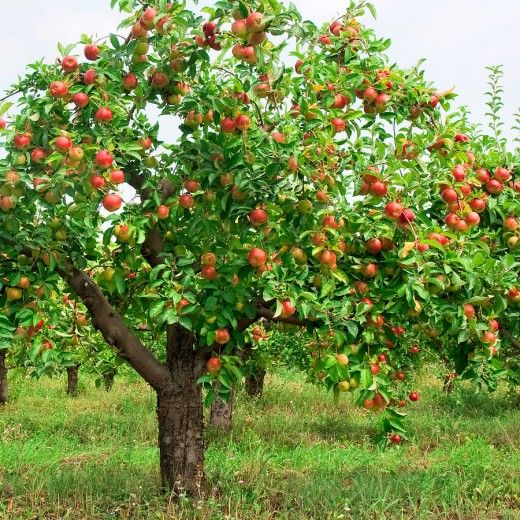

In [57]:
img = Image.open("/content/fruit_tree.jpg").convert("RGB")
img

## Encoding:

In [58]:
img = preprocess(img).unsqueeze(0).to(device)  # Preprocess and add a batch dimension

with torch.no_grad():
    uploaded_image_features = resnet_model(img).squeeze()

## Similarity:

In [60]:
uploaded_image_features_np = uploaded_image_features.cpu().numpy()
distances = euclidean_distances(uploaded_image_features_np.reshape(1, -1), resnet_features.cpu().numpy()).flatten()
top_k_indices = distances.argsort()[:5]
top_k_indices

array([29803, 30035, 30048,  3103, 30036])

In [61]:
def display_similar_images(top_indices, dataset, labels):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(top_indices):
        image, label = dataset[idx]
        plt.subplot(1, len(top_indices), i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Permute the image for display (C, H, W) -> (H, W, C)
        plt.title(f"Category: {caltech256.categories[labels[idx]]}")
        plt.axis('off')
    plt.show()


Top 5 similar images to the uploaded image:


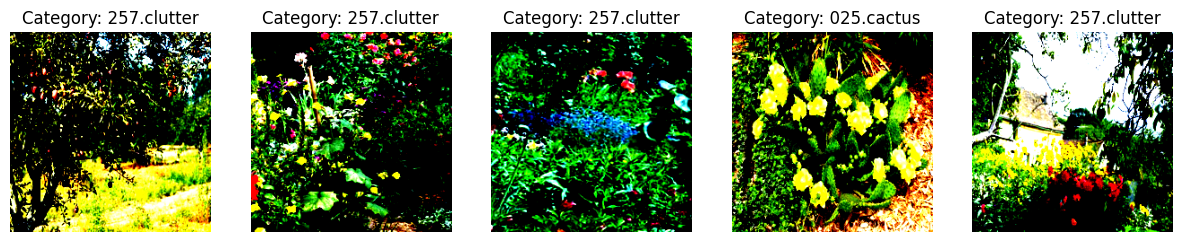

In [62]:
print("\nTop 5 similar images to the uploaded image:")
display_similar_images(top_k_indices, caltech256, labels)

## CBIR Performance Evaluation:

Select 100 indices

In [46]:
random_indices = np.array([ 8153,  7119, 16180,  4609, 25123, 15526, 20439,  2453,  1130, 3298, 27023, 15999, 16062,  6199,  7214, 25768, 13188,  3905, 4002, 10923, 19335, 28504, 13180, 12051, 16704, 24288,  3076, 14994, 24382, 25161,  4341, 10762, 13192, 23363, 30054, 22164, 28879, 21069,  8786,  4232, 19932,  5902, 14230, 13731, 28143, 10307, 15695, 23724,  2014, 14552,   576, 16124, 25022, 10407, 10108, 20941,  1211, 22070, 24498,   929,  6493, 14005,  8856, 22875, 15658, 7964, 19048,  5470,  3874, 20965, 10458, 23041, 24038, 18835, 723, 1518, 7470, 6254, 8094, 30113, 20290, 23163, 279, 23985, 26133, 1048, 8825, 2658, 14922, 17948, 17873, 14217, 12475, 12515, 20745, 21105, 2079, 28200, 18144, 11792])
len(random_indices)

100

Retrieve function that returns accuracy of each retrieval

In [63]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

def retrieve_similar_images(query_index, encoded_features, dataloader, labels, k=10):
    """
    Retrieve and print the top-k similar images based on Euclidean distance, along with their labels.
    Returns a score indicating how many retrieved images share the same label as the query image.

    Args:
    - query_index (int): Index of the query image in the dataset.
    - encoded_features (torch.Tensor): Encoded features of all images in the dataset.
    - dataloader (torch.utils.data.DataLoader): Dataloader containing the dataset images.
    - labels (list): List of labels corresponding to the dataset images.
    - k (int): Number of similar images to retrieve (default is 10).

    Returns:
    - score (int): Number of retrieved images with the same label as the query image.
    """

    # Access the dataset from the dataloader
    dataset = dataloader.dataset

    # Convert encoded features to numpy if it's a tensor
    encoded_features_np = encoded_features.cpu().numpy() if isinstance(encoded_features, torch.Tensor) else encoded_features

    # Step 1: Extract the query image feature vector
    query_feature = encoded_features_np[query_index].reshape(1, -1)

    # Step 2: Compute Euclidean distances between the query feature and all other features
    distances = euclidean_distances(query_feature, encoded_features_np).flatten()

    # Step 3: Get the indices of the top-k closest images (excluding the query image itself)
    top_k_indices = distances.argsort()[:k + 1]  # Get k+1 to include the query image itself

    # Step 4: Display the query image and the top-k similar images
    query_image, _ = dataset[query_index]  # Extract the query image from the dataset

    # Initialize score counter
    score = 0

    # Plot the query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, k + 1, 1)
    plt.imshow(query_image.permute(1, 2, 0))  # Change dimensions to HxWxC for plotting
    plt.title(f'Query Image\nLabel: {labels[query_index]}')
    plt.axis('off')

    for i, idx in enumerate(top_k_indices[1:k + 1]):  # Skip the first one as it is the query image itself
        similar_image, _ = dataset[idx]  # Get the similar image
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(similar_image.permute(1, 2, 0))  # Change dimensions to HxWxC for plotting
        plt.title(f"Rank {i + 1}\nLabel: {labels[idx]}")
        plt.axis('off')

        # Check if the label matches the query label
        if labels[idx] == labels[query_index]:
            score += 1
    plt.show()

    return score

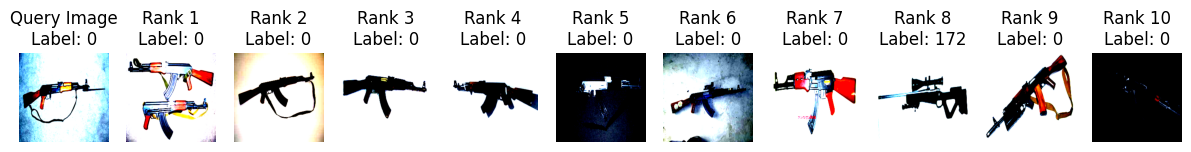

9

In [64]:
retrieve_similar_images(query_index=0, encoded_features=resnet_features, dataloader=dataloader, labels=labels, k=10)

In [ ]:
accuracies = []
for index in random_indices:
    score = retrieve_similar_images(query_index=index, encoded_features=resnet_features, dataloader=dataloader, labels=labels, k=10)
    accuracies.append(score)
accuracies_array = np.array(accuracies)
print("Accuracies for each query image:", accuracies_array)

Output cleared to reduce file space

In [66]:
np.mean(accuracies_array)

7.39